# Install Packages

In this approach data is segmented and feature are calculated for each segment. Then these features are averaged.

Butterworth is applied before segmentation
Classifier are tuned before feature selection.
Butterworth ranges from .1 to 30 HZ

In [0]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [0]:
!pip install wfdb
!pip install mne
!pip install nitime

In [0]:
!pip install git+https://github.com/forrestbao/pyeeg.git
!pip install git+https://github.com/raphaelvallat/entropy.git

  Cloning https://github.com/forrestbao/pyeeg.git to /tmp/pip-req-build-ca93mjp_
  Running command git clone -q https://github.com/forrestbao/pyeeg.git /tmp/pip-req-build-ca93mjp_
  Created wheel for pyeeg: filename=pyeeg-0.4.4-py2.py3-none-any.whl size=28121 sha256=494294feda369e52047e75f914fe98ff60c84faab33e3a9a8584a16b94cada28
  Stored in directory: /tmp/pip-ephem-wheel-cache-rmswa6f_/wheels/2d/3f/ad/106d4fc80b61d1ea1fc18e76e7439fd98aa043d83d58eae741
Successfully built pyeeg
  Cloning https://github.com/raphaelvallat/entropy.git to /tmp/pip-req-build-4aa3p9_r
  Running command git clone -q https://github.com/raphaelvallat/entropy.git /tmp/pip-req-build-4aa3p9_r
  Created wheel for entropy: filename=entropy-0.1.0-cp36-none-any.whl size=14098 sha256=4f5426df27f6485c8ae7dd8c1a686323dc2183c2a1cf257743197b55e0df50f3
  Stored in directory: /tmp/pip-ephem-wheel-cache-a00sebf3/wheels/60/ed/d3/b715e38438f1f39edb1383aea79c578073953b25fa576fc71e
Successfully built entropy


# Download data

In [0]:
import wfdb
dbs = wfdb.get_dbs()
wfdb.dl_database('eegmat','data')

Finished downloading files


# Read data

In [0]:
import glob
import os
import mne
import re
import numpy as np


/usr/local/lib/python3.6/dist-packages/numba/decorators.py:146: RuntimeWarning: Caching is not available when the 'parallel' target is in use. Caching is now being disabled to allow execution to continue.
  warnings.warn(msg, RuntimeWarning)


In [0]:
from scipy import signal

nyq = 0.5 * 500
l=0.1
low = l / nyq
high = 45 / nyq
b, a = signal.butter(4, [low,high], 'band')

In [77]:

path = r'data/' # use your path
all_files = glob.glob(os.path.join(path, "*.edf")) 

i=0
j=0
subject_1=[]
subject_2=[]

for filename in (all_files):
    if int(re.findall(r'\d+',filename)[1])==1:
        data=mne.io.read_raw_edf(filename,preload=True).get_data()[0:-3,10000:40000]
        data=signal.filtfilt(b, a, data)  
        subject_1.append(data.T)
    else:
        data=mne.io.read_raw_edf(filename,preload=True).get_data()[0:-3,0:30000]
        data=signal.filtfilt(b, a, data)  
        subject_2.append(data.T)        

Extracting EDF parameters from /content/data/Subject32_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Extracting EDF parameters from /content/data/Subject14_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Extracting EDF parameters from /content/data/Subject10_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 93999  =      0.000 ...   187.998 secs...
Extracting EDF parameters from /content/data/Subject02_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Extracting EDF parameters from /content/data/Subject09_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   1

# Feature Extraction

In [0]:
from scipy import stats
import pyeeg
from entropy import *
import pywt
from nitime import algorithms as alg


In [0]:
def mean(data):
    return np.mean(data,axis=0)
    
def std(data):
    return np.std(data,axis=0)

def ptp(data):
    return np.ptp(data,axis=0)

def var(data):
        return np.var(data,axis=0)

def skewness(data):
    return stats.skew(data,axis=0)

def kurtosis(data):
    return stats.kurtosis(data,axis=0)

def app_epy(data):
    result=[]
    for i in data.T:
        result.append(app_entropy(i, order=2, metric='chebyshev'))
    return np.array(result)

def perm_epy(data):
    result=[]
    for i in data.T:
        result.append(perm_entropy(i, order=3, normalize=True))
    return np.array(result)

def svd_epy(data):
    result=[]
    for i in data.T:
        result.append(svd_entropy(i, order=3, delay=1, normalize=True))
    return np.array(result)

def spectral_epy(data):
    result=[]
    for i in data.T:
        result.append(spectral_entropy(i, 100, method='welch', normalize=True))
    return np.array(result)

def sample_epy(data):
    result=[]
    for i in data.T:
        result.append(sample_entropy(i, order=2, metric='chebyshev'))
    return np.array(result)


def katz(data):
    result=[]
    for i in data.T:
        result.append(katz_fd(i))
    return np.array(result)

def higuchi(data):
    result=[]
    for i in data.T:
        result.append(higuchi_fd(i))
    return np.array(result)


def petrosian(data):
    result=[]
    for i in data.T:
        result.append(petrosian_fd(i))
    return np.array(result)

def autogressiveModelParameters(data):
    feature = []
    for i in data.T:
        coeff, sig = alg.AR_est_YW(i, order=5)
        feature.append(np.mean(coeff))
    return np.array(feature)

def teager(x):
    for i in range(len(x)-1):
        return x[i]**2 - (x[i-1]*x[i+1])

def wavelet_features(data):
    dwt={}
    for i in range(18):
        dwt[i]=pywt.wavedec(data.T[i],"db1", level=4)
    mean=[]
    tkeo=[]
    for i in dwt.values():
        for j in range(5):
            mean.append(i[j].mean())
            tkeo.append(teager(i[j]))
    return np.array(tkeo),np.array(mean)

def dwt_mean(data):
    _,mean= wavelet_features(data)
    return mean
    
def dwt_tkeo(data):
    tkeo,_= wavelet_features(data) 
    return tkeo
        

def concatenate(data):
    return np.concatenate((mean(data),std(data),ptp(data),var(data),skewness(data),kurtosis(data),
                           app_epy(data),perm_epy(data),svd_epy(data),spectral_epy(data),sample_epy(data),
                           katz(data),higuchi(data),petrosian(data),autogressiveModelParameters(data),dwt_mean(data),
                           dwt_tkeo(data)),axis=0)


In [0]:
features1=[]
for f in subject_1:
    feature=[]
    b=f.reshape(-1,3000,18)
    for i in b:
        feature.append(concatenate(i))
    features1.append(np.mean(np.array(feature),axis=0))

In [0]:
features2=[]
for f in subject_2:
    feature=[]
    b=f.reshape(-1,3000,18)
    for i in b:
        feature.append(concatenate(i))
    features2.append(np.mean(np.array(feature),axis=0))

In [82]:
len(features1),len(features2)

(36, 36)

In [0]:
x1=np.array(features1)        
x2=np.array(features2)      

X=np.concatenate((x1,x2),axis=0)

y=np.concatenate(((np.zeros(x1.shape[0])),(np.ones(x2.shape[0]))))

In [84]:
X.shape,y.shape

((72, 450), (72,))

# Classification

In [0]:
#%% split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=42,stratify=y)

In [0]:
from sklearn.preprocessing import StandardScaler,MaxAbsScaler
sc=StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)

In [87]:
from sklearn.svm import SVC
clf=SVC(kernel='rbf')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

from sklearn.metrics import classification_report,accuracy_score
print(classification_report(y_test,y_pred))
print('accuracy is ',accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.78      0.88      0.82         8
         1.0       0.83      0.71      0.77         7

    accuracy                           0.80        15
   macro avg       0.81      0.79      0.80        15
weighted avg       0.80      0.80      0.80        15

accuracy is  0.8


# Fine Tuning

In [88]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

clf = SVC(kernel="rbf")
Cs = [ 1,2,3,5,7,10,15,30,50,70,100]
gammas = [0.001,0.01,0.02,0.03,0.04,0.05,0.1,0.3,0.5,0.8,1]
pipe = Pipeline(steps=[('scaler', sc), ('classifier', clf)])
estimator = GridSearchCV(pipe,
                         dict(classifier__C=Cs,classifier__gamma=gammas),cv=5,n_jobs=-1,iid=False) 

results = estimator.fit(X,y)
results.best_params_

{'classifier__C': 2, 'classifier__gamma': 0.001}

### KNN

In [89]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier()

n_neighbors  = [ 3,4,5,6,7,8,9]
weights  = ['uniform','distance']
metric=['minkowski','manhattan','euclidean']
pipe = Pipeline(steps=[('scaler', sc), ('classifier', clf)])
estimator = GridSearchCV(pipe,
                         dict(classifier__n_neighbors=n_neighbors,classifier__weights=weights,classifier__metric=metric),cv=5,n_jobs=-1,iid=False) 
results = estimator.fit(X,y)
results.best_params_


{'classifier__metric': 'minkowski',
 'classifier__n_neighbors': 6,
 'classifier__weights': 'distance'}

### nu

In [90]:
from sklearn.svm import SVC, LinearSVC, NuSVC

clf = NuSVC(kernel="rbf")
nu = [0.1,0.3,0.5,0.7,1]
gammas = [0.001,0.01,0.02,0.03,0.04,0.05,0.1,0.3,0.5,0.8,1]
pipe = Pipeline(steps=[('scaler', sc), ('classifier', clf)])
estimator = GridSearchCV(pipe,
                         dict(classifier__nu=nu,classifier__gamma=gammas),cv=5,n_jobs=-1,iid=False) 

results = estimator.fit(X,y)
results.best_params_

{'classifier__gamma': 0.001, 'classifier__nu': 0.3}

### lR

In [91]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
C = [ 1,2,3,5,7,10,15,30,50,70,100]
penalty=["l1","l2"]
pipe = Pipeline(steps=[('scaler', sc), ('classifier', clf)])
estimator = GridSearchCV(pipe,
                         dict(classifier__C=C,classifier__penalty=penalty),cv=5,n_jobs=-1,iid=False) 

results = estimator.fit(X,y)
results.best_params_

{'classifier__C': 1, 'classifier__penalty': 'l2'}

# Cross Validation

In [0]:

from sklearn.preprocessing import StandardScaler,MaxAbsScaler

scalar=StandardScaler()

In [0]:
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
import pandas as pd
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score

In [0]:
classifiers = [
    KNeighborsClassifier(n_neighbors=6,weights='distance',metric='minkowski'),
    SVC(kernel="rbf",C=2,gamma=0.001),
    NuSVC(nu=0.3,gamma=0.001),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression(C=1,penalty='l2')]


In [0]:
pipeline = Pipeline([('transformer', scalar),('estimator', clf)])

In [96]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

accuracy=[]
accuracy_std=[]
f1_scores=[]
f1_scores_std=[]
for clfs in classifiers:
    pipeline.set_params(estimator = clfs)
    name = clfs.__class__.__name__
    
    print("="*30)
    print(name)       
    print('****Results****')
    scores = cross_val_score(pipeline, X, y, cv=5)
    #f1_score = cross_val_score(clf, X_rfe, y, cv=5,scoring='f1')
    print("Accuracy: {:.4%}".format(np.array(scores).mean()))
    accuracy.append(np.array(scores).mean())
    accuracy_std.append(np.array(scores).std())
    #f1_scores.append(np.array(f1_score).mean())
    #f1_scores_std.append(np.array(f1_score).std())

KNeighborsClassifier
****Results****
Accuracy: 76.7857%
SVC
****Results****
Accuracy: 77.8571%
NuSVC
****Results****
Accuracy: 76.4286%
DecisionTreeClassifier
****Results****
Accuracy: 56.7857%
RandomForestClassifier
****Results****
Accuracy: 65.1786%
AdaBoostClassifier
****Results****
Accuracy: 72.1429%
GradientBoostingClassifier
****Results****
Accuracy: 51.6071%
GaussianNB
****Results****
Accuracy: 66.2500%
LinearDiscriminantAnalysis
****Results****
Accuracy: 66.7857%
QuadraticDiscriminantAnalysis
****Results****
Accuracy: 51.0714%
LogisticRegression
****Results****
Accuracy: 76.4286%


/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.6/dist-packages/sklearn/d

Text(0.5, 1.0, 'Classifiers')

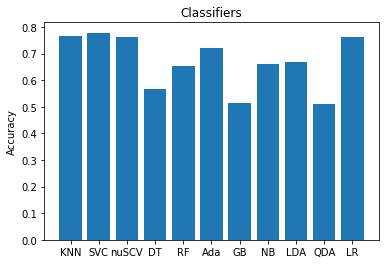

In [97]:
import matplotlib.pyplot as plt
classifier=['KNN','SVC','nuSCV','DT','RF','Ada','GB','NB','LDA','QDA','LR']
y_pos = np.arange(len(classifier))
plt.bar(y_pos,np.array(accuracy))
plt.xticks(y_pos, classifier)
plt.ylabel('Accuracy')
plt.title('Classifiers')

# Principle Component Analysis

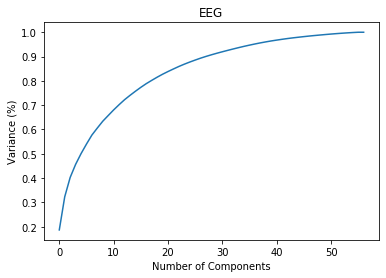

In [98]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import cross_val_score

#Fitting the PCA algorithm with our Data
pca = PCA().fit(X_train)
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('EEG')
plt.show()

In [0]:

clf = SVC(kernel='rbf')
pca = PCA(n_components=40)

pipeline = Pipeline([('transformer', scalar),('selector',pca), ('estimator', clf)])


In [100]:

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

accuracy_pca=[]
std_pca=[]
f1_scores=[]
f1_scores_std=[]
for clfs in classifiers:
    pipeline.set_params(estimator = clfs)
    name = clfs.__class__.__name__
    
    print("="*30)
    print(name)       
    print('****Results****')
    scores = cross_val_score(pipeline, X, y, cv=5)
    #f1_score = cross_val_score(clf, X_rfe, y, cv=5,scoring='f1')
    print("Accuracy: {:.4%}".format(np.array(scores).mean()))
    accuracy_pca.append(np.array(scores).mean())
    std_pca.append(np.array(scores).std())
    #f1_scores.append(np.array(f1_score).mean())
    #f1_scores_std.append(np.array(f1_score).std())


KNeighborsClassifier
****Results****
Accuracy: 69.6429%
SVC
****Results****
Accuracy: 79.1071%
NuSVC
****Results****
Accuracy: 70.8929%
DecisionTreeClassifier
****Results****
Accuracy: 56.0714%
RandomForestClassifier
****Results****
Accuracy: 55.7143%
AdaBoostClassifier
****Results****
Accuracy: 71.9643%
GradientBoostingClassifier
****Results****
Accuracy: 54.2857%
GaussianNB
****Results****
Accuracy: 65.1786%
LinearDiscriminantAnalysis
****Results****
Accuracy: 69.6429%
QuadraticDiscriminantAnalysis
****Results****
Accuracy: 56.9643%
LogisticRegression
****Results****
Accuracy: 72.3214%


/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


# RFE

In [0]:
from sklearn.preprocessing import MaxAbsScaler,StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE


In [0]:
# from sklearn.model_selection import GridSearchCV

# clf = SVC(kernel="rbf")
# n_features = [20,30,40,50,70,100]
# step=[5,7,9,10]
# Cs = [0.001,0.1, 1,2,3,5,7,10,15,30]
# gammas = [0.001,0.01,0.02,0.03,0.04,0.05,0.1,0.3,0.5,0.8,1]
# pipe = Pipeline(steps=[('rfe', rfe), ('classifier', clf)])
# estimator = GridSearchCV(pipe,
#                          dict(rfe__step=step,rfe__n_features_to_select=n_features,
#                               classifier__C=Cs,classifier__gamma=gammas),cv=5,n_jobs=-1,iid=False) 

# results = estimator.fit(X,y)
# results.best_params_

In [0]:

clf = SVC(kernel='rbf')
rfe=RFE(SVC(kernel='linear'),n_features_to_select=120,step=5,verbose=0)   

pipeline = Pipeline([('transformer', scalar),('selector',rfe), ('estimator', clf)])


In [104]:

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

accuracy_rfe=[]
std_rfe=[]
f1_scores=[]
f1_scores_std=[]
for clfs in classifiers:
    pipeline.set_params(estimator = clfs)
    name = clfs.__class__.__name__
    
    print("="*30)
    print(name)       
    print('****Results****')
    scores = cross_val_score(pipeline, X, y, cv=5)
    #f1_score = cross_val_score(clf, X_rfe, y, cv=5,scoring='f1')
    print("Accuracy: {:.4%}".format(np.array(scores).mean()))
    accuracy_rfe.append(np.array(scores).mean())
    std_rfe.append(np.array(scores).std())
    #f1_scores.append(np.array(f1_score).mean())
    #f1_scores_std.append(np.array(f1_score).std())


KNeighborsClassifier
****Results****
Accuracy: 66.7857%
SVC
****Results****
Accuracy: 71.0714%
NuSVC
****Results****
Accuracy: 61.0714%
DecisionTreeClassifier
****Results****
Accuracy: 52.1429%
RandomForestClassifier
****Results****
Accuracy: 58.2143%
AdaBoostClassifier
****Results****
Accuracy: 62.1429%
GradientBoostingClassifier
****Results****
Accuracy: 51.6071%
GaussianNB
****Results****
Accuracy: 68.0357%
LinearDiscriminantAnalysis
****Results****


/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Accuracy: 58.3929%
QuadraticDiscriminantAnalysis
****Results****


/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Accuracy: 44.2857%
LogisticRegression
****Results****
Accuracy: 68.0357%


# SKbest

In [0]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif


In [0]:

clf = SVC(kernel='rbf')
skbest=SelectKBest(f_classif, k=5)
pipeline = Pipeline([('transformer', scalar),('selector',rfe), ('estimator', clf)])


In [107]:

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

accuracy_kbest=[]
std_kbest=[]
f1_scores=[]
f1_scores_std=[]
for clfs in classifiers:
    pipeline.set_params(estimator = clfs)
    name = clfs.__class__.__name__
    
    print("="*30)
    print(name)       
    print('****Results****')
    scores = cross_val_score(pipeline, X, y, cv=5)
    #f1_score = cross_val_score(clf, X_rfe, y, cv=5,scoring='f1')
    print("Accuracy: {:.4%}".format(np.array(scores).mean()))
    accuracy_kbest.append(np.array(scores).mean())
    std_kbest.append(np.array(scores).std())
    #f1_scores.append(np.array(f1_score).mean())
    #f1_scores_std.append(np.array(f1_score).std())


KNeighborsClassifier
****Results****
Accuracy: 66.7857%
SVC
****Results****
Accuracy: 71.0714%
NuSVC
****Results****
Accuracy: 61.0714%
DecisionTreeClassifier
****Results****
Accuracy: 52.3214%
RandomForestClassifier
****Results****
Accuracy: 63.7500%
AdaBoostClassifier
****Results****
Accuracy: 62.1429%
GradientBoostingClassifier
****Results****
Accuracy: 54.2857%
GaussianNB
****Results****
Accuracy: 68.0357%
LinearDiscriminantAnalysis
****Results****


/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Accuracy: 58.3929%
QuadraticDiscriminantAnalysis
****Results****


/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Accuracy: 44.2857%
LogisticRegression
****Results****
Accuracy: 68.0357%


# VarianceThreshold

In [0]:
from sklearn.feature_selection import VarianceThreshold
clf = SVC(kernel='rbf')
selector = VarianceThreshold(0.3)
pipeline = Pipeline([('transformer', scalar),('selector',selector), ('estimator', clf)])


In [121]:

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

accuracy_var=[]
std_var=[]
f1_scores=[]
f1_scores_std=[]
for clfs in classifiers:
    pipeline.set_params(estimator = clfs)
    name = clfs.__class__.__name__
    
    print("="*30)
    print(name)       
    print('****Results****')
    scores = cross_val_score(pipeline, X, y, cv=5)
    #f1_score = cross_val_score(clf, X_rfe, y, cv=5,scoring='f1')
    print("Accuracy: {:.4%}".format(np.array(scores).mean()))
    accuracy_var.append(np.array(scores).mean())
    std_var.append(np.array(scores).std())
    #f1_scores.append(np.array(f1_score).mean())
    #f1_scores_std.append(np.array(f1_score).std())


KNeighborsClassifier
****Results****
Accuracy: 76.7857%
SVC
****Results****
Accuracy: 77.8571%
NuSVC
****Results****
Accuracy: 76.4286%
DecisionTreeClassifier
****Results****
Accuracy: 56.7857%
RandomForestClassifier
****Results****
Accuracy: 64.1071%
AdaBoostClassifier
****Results****
Accuracy: 70.7143%
GradientBoostingClassifier
****Results****
Accuracy: 45.8929%
GaussianNB
****Results****
Accuracy: 66.2500%
LinearDiscriminantAnalysis
****Results****
Accuracy: 66.7857%
QuadraticDiscriminantAnalysis
****Results****
Accuracy: 51.0714%
LogisticRegression
****Results****
Accuracy: 76.4286%


/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.6/dist-packages/sklearn/d

In [122]:
len(accuracy),len(accuracy_pca),len(accuracy_rfe),len(accuracy_kbest),len(accuracy_var)

(11, 11, 11, 11, 11)

In [0]:
result=pd.DataFrame([accuracy,accuracy_pca,accuracy_rfe,accuracy_kbest,accuracy_var],
                    index=['Accuracy','PCA',"RFE",'kbest','VAR'],
                    columns=['KNN','SVC','nuSCV','DT','RF','Ada','GB','NB','LDA','QDA','LR'])

In [0]:
result=result.T

In [125]:
def _color_red_or_green(val):
    color = 'red' if val < 0.7 else 'green'
    return 'color: %s' % color
result.style.applymap(_color_red_or_green)    

,Accuracy,PCA,RFE,kbest,VAR
KNN,0.767857,0.696429,0.667857,0.667857,0.767857
SVC,0.778571,0.791071,0.710714,0.710714,0.778571
nuSCV,0.764286,0.708929,0.610714,0.610714,0.764286
DT,0.567857,0.560714,0.521429,0.523214,0.567857
RF,0.651786,0.557143,0.582143,0.6375,0.641071
Ada,0.721429,0.719643,0.621429,0.621429,0.707143
GB,0.516071,0.542857,0.516071,0.542857,0.458929
NB,0.6625,0.651786,0.680357,0.680357,0.6625
LDA,0.667857,0.696429,0.583929,0.583929,0.667857
QDA,0.510714,0.569643,0.442857,0.442857,0.510714
